# A sequential generative model for MNIST

The PixelCNN [1] generates images through the conditional probabilities. The model fits the probability $p(x_i | x_{<i})$.
* During training: we need to from training pairs (x_{<i}, x_i) and use these pairs to train the model.
* During generation, we loop through $i=0, \ldots, d-1$, and generate each pixel $x_i$ through a sample $p(x_i | x_{<i})$.


**Work to complete**:
1. [2 points] create the CNN model. You may want to start with a simple network and then gradually increase its depth/width.
2. [2 points] set up the training loop. Please remember to call the function "form_conditional_samples"
3. [4 points] train the model. After training, please show the test loss in each epoch. The test loss should descent with the training epochs.
4. [2 points] show the generate examples.
5. [5 points] There are two sub-questions below. Please answer these two questions before or after the coding part.


**Extra notes**:
1. Please use LLMs (Gemini associated with the notebook or others) to generate the code for each cell. Free versions of LLMs are sufficient for the work. You can use Claude or GPT by typing the prompts there and copying the code back to the notebook.

2. With your Tufts email, you can apply for GPU computation credits. Please do apply for the credits early.

3. You are reponsible for the correctness of the the code, not the LLM.



[1] Aäron van den Oord, Nal Kalchbrenner, Oriol Vinyals, Lasse Espeholt, Alex Graves, and Koray Kavukcuoglu. 2016. Conditional image generation with PixelCNN decoders. In Proceedings of the 30th International Conference on Neural Information Processing Systems (NIPS'16). Curran Associates Inc., Red Hook, NY, USA, 4797–4805.

**Sub-question 5.1** (2 points). Suppose we want the model to predict $x_i$ at the $i$-th step, why are we so strict about not letting the model using entries after $i$? What's the consequence if we forget to mask out all bits after $i - 1$?

**Answer:** If we allow the model to use entries after $i$, then it would have access to future pixels when making a prediction. This would make training inconsistent with generation. During generation, the model only has access to previously generate pixels ($x_1, \dots, x_{i-1}$), not future ones. Without masking, the model could "cheat" by looking at the true future pixels, leading to artificially low training loss but poor generation performance, since it would no longer have access to future pixels.

**Sub-question 5.3** (3 points). Suppose we take a random batch of test instances and select random locations for each test instance to compute a test loss for plotting and monitoring the training progress. Is the test loss an unbiased estimation of the log-likelihood of test instances? Please given an answer and explain your reason. Please remember: our goal is to maximize the log-likelihood of *test* data to avoid overfitting.

**Answer:** With proper scaling, the test loss is an unbiased estimation of the log-likelihood of test instances.

The full log-likelihood is
$$
    \log p(x) = \sum_{n=1}^N \sum_{d=1}^D \log p(x_{n,d} \mid x_{n,<d}).
$$
If we take a random batch of test instances and select random locations for each test instance the unbiased estimator is
$$
    \log p(x) \approx \frac{N}{\left|B\right|} \sum_{b \in B} \frac{D}{\left|S_b\right|} \sum_{d \in S_b} \log p(x_{b,d} \mid x_{b,<d}).
$$
Without proper scaling, the test loss is not an unbiased estimation of the log-likelihood of test instances but the optimization process will yield similar results.

## Download and prepare data

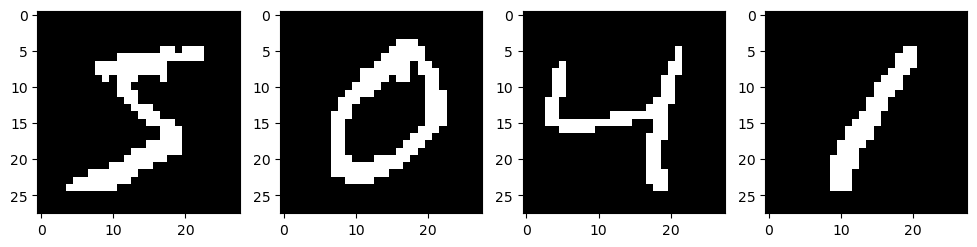

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_images = trainset.data.numpy()
test_images = testset.data.numpy()

# Let's work on the simple case and make mnist binary data

train_images = (train_images > 128).astype(np.float32)
test_images = (test_images > 128).astype(np.float32)

# show a few images from the training set

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
for idx, img in enumerate(train_images[:4]):
    axes[idx].imshow(img, cmap='gray')



## Define the mdoel

In [2]:
# Please create your model here

class CNN(torch.nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=128 * 7 * 7, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x.squeeze(-1)



## Forming random batches

For each instance x, get the training example: $(x_{<i}, x_i)$, with $x_{<i}$ being the neural network input, and $x_i$ being the predicting target.


In [3]:
# Given a batch of images, randomly generate positions to create samples for conditional distributions

# Let x_batch be a batch of samples with shape [B, d]
# Randomly generate B integers in range [0, d), each integer pointing to one of d elements.
# This element is the target, and the elements before this element are conditions, and the elements afterward are not observed
#


def form_conditional_samples(x_batch):
    """
    Convert a batch of B images to conditional samples.
    First generate B integers, each of which indexes the target, while the pixels before the index
    are the condition, and pixels after the index are not observed.
    Then for each instance, create three channels.
      - The first channel is 1 if the original value is 0 and before the target,
      - The second channel is 1 if the original value is 1 and before the target,
      - The third channel is 1 if the pixels are the target or after the target pixel.
    The target is a vector containing the targe of each image in the batch
    """
    B, H, W = x_batch.shape
    N = H * W  # total pixels
    x_flat = x_batch.view(B, N)

    # Random target index for each image
    target_idx = torch.randint(low=0, high=N, size=(B,))

    # Initialize output tensor: [B, 3, H, W]
    #out = torch.zeros(B, 3, H, W, dtype=torch.float32)
    out = torch.zeros(B, 3, N, dtype=torch.float32)
    target = torch.zeros(B, dtype=torch.float32)

    for i in range(B):
        idx = target_idx[i]
        # Pixels before target
        before = x_flat[i, :idx]
        # Pixels after (including) target
        after = x_flat[i, idx:]

        # First channel: 1 if pixel is 0 and before target
        ch1 = (before == 0).float()
        # Second channel: 1 if pixel is 1 and before target
        ch2 = (before == 1).float()
        # Third channel: 1 for target and after
        ch3 = torch.ones_like(after)

        # Combine channels and reshape
        out[i, 0, :idx] = ch1
        out[i, 1, :idx] = ch2
        out[i, 2, idx:] = ch3

        target[i] = x_flat[i, idx]
        
    out = out.view(B, 3, H, W)

    return out, target


x_batch.shape: torch.Size([64, 3, 28, 28])
y_batch.shape: torch.Size([64])


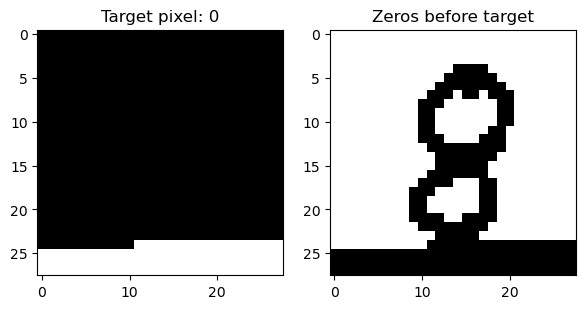

In [4]:
# Now please generate the dataloader that load batches of training examples. Each batch should be converted using the function above.

class ConditionalDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx] if self.transform is None else self.transform(self.images[idx])

def collate_conditional(batch):
    x_batch = torch.stack(batch, dim=0)
    out, target = form_conditional_samples(x_batch)
    return out, target

train_dataset = ConditionalDataset(train_images, lambda image: torch.from_numpy(image))
test_dataset = ConditionalDataset(test_images, lambda image: torch.from_numpy(image))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_conditional)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate_conditional)

x_batch, y_batch = next(iter(train_dataloader))
print(f"x_batch.shape: {x_batch.shape}")
print(f"y_batch.shape: {y_batch.shape}")

i = 0

ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(3*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[0].imshow(x_batch[i,2].numpy(), cmap='gray')
axs[0].set_title(f"Target pixel: {int(y_batch[i].item())}")

axs[1].imshow(x_batch[i,0].numpy(), cmap='gray')
axs[1].set_title("Zeros before target")
    
fig.tight_layout()
plt.show()

## Now we form the training loop

In [5]:
def train_one_epoch(model, criterion, optimizer, dataloader):
    
    device = next(model.parameters()).device
    model.train()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    running_loss = 0.0
    
    for x, y in dataloader:
        
        batch_size = len(x)
        
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += (batch_size / dataset_size) * loss.item()

    return running_loss

def evaluate(model, criterion, dataloader):

    device = next(model.parameters()).device
    model.eval()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    running_loss = 0.0
    
    with torch.no_grad():
        for x, y in dataloader:

            batch_size = len(x)

            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += (batch_size / dataset_size) * loss.item()

    return running_loss


In [6]:
lr = 0.001
num_epochs = 100

# Define loss function and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN()
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    
    train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader)
    test_loss = evaluate(model, criterion, test_dataloader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


cuda:0
Epoch [1/100], Loss: 0.2305
Epoch [2/100], Loss: 0.1330
Epoch [3/100], Loss: 0.1214
Epoch [4/100], Loss: 0.1124
Epoch [5/100], Loss: 0.1085
Epoch [6/100], Loss: 0.1022
Epoch [7/100], Loss: 0.1019
Epoch [8/100], Loss: 0.1033
Epoch [9/100], Loss: 0.0988
Epoch [10/100], Loss: 0.0953
Epoch [11/100], Loss: 0.0957
Epoch [12/100], Loss: 0.0970
Epoch [13/100], Loss: 0.0932
Epoch [14/100], Loss: 0.0949
Epoch [15/100], Loss: 0.0925
Epoch [16/100], Loss: 0.0916
Epoch [17/100], Loss: 0.0914
Epoch [18/100], Loss: 0.0886
Epoch [19/100], Loss: 0.0902
Epoch [20/100], Loss: 0.0893
Epoch [21/100], Loss: 0.0900
Epoch [22/100], Loss: 0.0923
Epoch [23/100], Loss: 0.0892
Epoch [24/100], Loss: 0.0875
Epoch [25/100], Loss: 0.0894
Epoch [26/100], Loss: 0.0902
Epoch [27/100], Loss: 0.0919
Epoch [28/100], Loss: 0.0923
Epoch [29/100], Loss: 0.0909
Epoch [30/100], Loss: 0.0893
Epoch [31/100], Loss: 0.0884
Epoch [32/100], Loss: 0.0902
Epoch [33/100], Loss: 0.0872
Epoch [34/100], Loss: 0.0884
Epoch [35/100], 

## Plot the curve of training and test losses

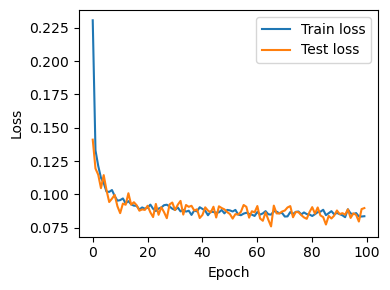

In [7]:
# Please plot your training and test losses against training epochs (or every say 1000 iterations) so you can make sure the model is trained properly.
# The optimization has converged, and there is not an obvious overfitting issue.

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(range(len(train_losses)), train_losses, label="Train loss")
ax.plot(range(len(test_losses)), test_losses, label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

fig.tight_layout()
plt.show()

## Generate images with the CNN model




In [8]:

# at each step, the input is the incomplete image. To generate the image:
# * Run the CNN to predict the next pixel.
# * Append it to the incomplete
# * loop over the two previous steps

def generate_image(model, H=28, W=28):

    device = next(model.parameters()).device
    model.eval()
    
    N = H * W
    generated = torch.zeros(N, dtype=torch.float32, device=device)

    for step in range(N):
        
        x_cond = torch.zeros(1, 3, N, device=device)

        before = generated[:step]
        after_len = N - step

        x_cond[0, 0, :step] = (before == 0).float().to(device)
        x_cond[0, 1, :step] = (before == 1).float().to(device)
        x_cond[0, 2, step:] = 1.0

        x_cond = x_cond.view(1, 3, H, W)

        with torch.no_grad():
            prob = torch.sigmoid(model(x_cond)).item()

        generated[step] = torch.bernoulli(torch.tensor(prob, device=device))

    return generated.view(H, W).cpu()

gen_x_batch = torch.stack([generate_image(model, H=28, W=28) for _ in range(4)])

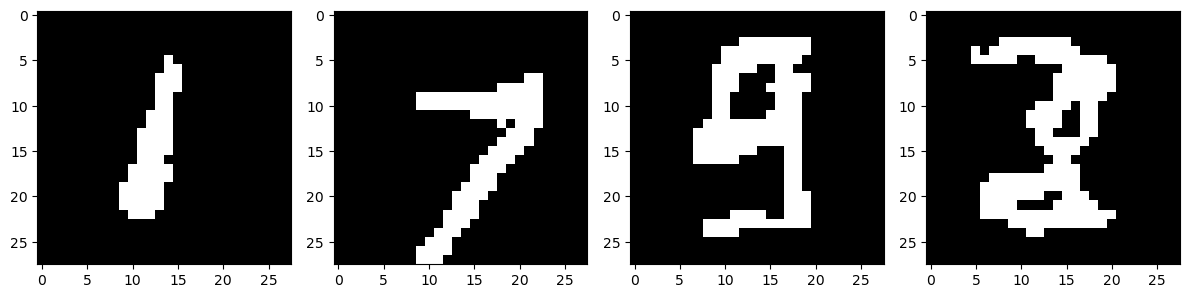

In [9]:
# Plot your generated images here

ncols, nrows = 4, 1
fig, axs = plt.subplots(figsize=(3*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[0].imshow(gen_x_batch[0].numpy(), cmap='gray')
axs[1].imshow(gen_x_batch[1].numpy(), cmap='gray')
axs[2].imshow(gen_x_batch[2].numpy(), cmap='gray')
axs[3].imshow(gen_x_batch[3].numpy(), cmap='gray')

fig.tight_layout()
plt.show()